# Iris feature extraction

In this notebook I'll explore several approaches for extracting features from normalized irises; more precisely ALL the approaches discussed in this notebook are based on deep learning, and they are the following:
- Vgg-16 as it is, **no fine tuning**
- Vgg-16 finetuned through **few-shot learning** (based on siamese networks)
- Vgg-16 finetuned thorugh **triplet few-shot learning** (also based on siamese networks)
- Custom CNN trained from scratch through **triplet few-shot learning** (also based on siamese networks) 

# Imports and installation of dependencies
This section is needed for installing and importing the libraries that will be used later on. Briefly, I'll use:
- Pytorch w/ Pytorch-lightning
- Numpy
- Pandas
- Scipy
- Matplotlib

## Installs

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 4.2 MB/s 
     |████████████████████████████████| 133 kB 43.6 MB/s 
     |████████████████████████████████| 952 kB 36.1 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 829 kB 21.7 MB/s 
     |████████████████████████████████| 397 kB 40.1 MB/s 
     |████████████████████████████████| 1.1 MB 32.6 MB/s 
     |████████████████████████████████| 144 kB 25.0 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 31.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6ac2bc145d3dd22bb76363ade0d767d089c40196f610d0f2596731bde06d4fdc
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

## Imports

In [ ]:
# For dealing with paths and drive system
import os
from google.colab import drive

# Numpy, Pandas
import numpy as np
import pandas as pd

# sklearn
from sklearn import preprocessing

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_image

# Pytorch lightning
import pytorch_lightning as pl 
from pytorch_lightning import Trainer

# plt
import matplotlib.pyplot as plt

## Drive & PyTorch device selection

In [ ]:
# Mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Enabling Nvidia GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cpu


## Some constants

In [ ]:
PROJECT_PATH = "drive/MyDrive/Project/"

UTIRIS_DATASET_BASE_PATH = os.path.join(PROJECT_PATH, "Utiris/RGB/")

# subpath
UTIRIS_DATASET_TRAIN_PATH = os.path.join(UTIRIS_DATASET_BASE_PATH, "train/utiris_train.csv")
UTIRIS_DATASET_TEST_PATH = os.path.join(UTIRIS_DATASET_BASE_PATH, "test/utiris_test.csv")

# Training
MAX_EPOCHS = 100

In [ ]:
# Utility functions
def imshow(img, text=None):
  npimg = img.numpy()
  plt.axis("off")
  print(text)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def randomSample(dataloader):
  return next(iter(dataloader))

# Models
In this section I'll define several classes that will represent *two main* things:
1. **Feature extractors:** these kind of models will be used for extracting features from the actual normalized iris images
2. **Feature extractor trainers:** these kind of models will be used for training or finetuning the feature extractors models. As said before we will approach three kind of training: 
  1. pair few-shot learning
  2. triplet few-shot learning
  3. simply loading pretrained weights (kinda a cheat)

## Feature extractors

### VGG Based feature extractor

In [ ]:
class VggFE(nn.Module):
  def __init__(self, pretrained=False):
    super(VggFE, self).__init__()
    model = models.vgg16(pretrained)
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)

    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]

  def forward(self, x):
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out

This feature extractor will give me a vector of 4096 features. Since we will test 3 different approaches on this feature extractor I create 3 instances of it (one will not be touched by training)

In [ ]:
# we load pretrained weights
vggFEPretrained = VggFE(pretrained=True)

vggFEPair = VggFE(pretrained=True)
vggFETriplet = VggFE(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Custom feature extractor
This feature extractor will be trained from scratch, this means that initial weights are set randomly (so training is harder). I'll base its structure on **FeatNet** from [here](https://ieeexplore.ieee.org/document/9036930), which seems to be very efficient.

In [ ]:
from collections import OrderedDict

class FeatNet(nn.Module):
    def __init__(self):
        super(FeatNet, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv1_a', nn.Conv2d(3, 16, kernel_size=(3, 7), stride=1, padding=(1, 3), bias=False)),
            ('tan1_a', nn.Tanh())
        ]))
        self.conv2 = nn.Sequential(OrderedDict([
            ('pool1_a', nn.AvgPool2d(kernel_size=2, stride=2)),
            ('conv2_a', nn.Conv2d(16, 32, kernel_size=(3, 5), stride=1, padding=(1, 2), bias=False)),
            ('tan2_a', nn.Tanh())
        ]))
        self.conv3 = nn.Sequential(OrderedDict([
            ('pool2_a', nn.AvgPool2d(kernel_size=2, stride=2)),
            ('conv3_a', nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)),
            ('tan3_a', nn.Tanh())
        ]))
        self.fuse_a = nn.Conv2d(112, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.flatten = nn.Flatten()
        

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x2 = F.interpolate(x2, size=(64, 200), mode='bilinear', align_corners=False)
        x3 = F.interpolate(x3, size=(64, 200), mode='bilinear', align_corners=False)
        x4 = torch.cat((x1, x2, x3), dim=1)
        out = self.fuse_a(x4)
        out = self.flatten(out)
        return out

In [ ]:
# instancing featnet
featNetTriplet = FeatNet()

## Trainers

### Pair few-shot learning

I start by defining the loss function which in this case will be the "*contrastive loss*".

![](https://miro.medium.com/max/1400/1*E6UUEmxKp5ZTRgCRNbIP-g.png)

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):
      super(ContrastiveLoss, self).__init__()
      self.margin = margin

  def forward(self, output1, output2, label):
    # Calculate the euclidian distance and calculate the contrastive loss
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

    return loss_contrastive

Then I define the actual **siamese neural network**

In [ ]:
# SNN stands for "Siamese Neural Network"
class SNN(pl.LightningModule):
  def __init__(self, model, trainingDataset, margin=1.0):
    super(SNN, self).__init__()
    
    # embedding model (I call it feature extractor)
    self.embeddingNet = model
    self.criterion = ContrastiveLoss(margin=margin)

    # training dataset
    self.trainingDataset = trainingDataset

  def forward(self, input1, input2):
    out1 = self.embeddingNet(input1)
    out2 = self.embeddingNet(input2)
    return out1, out2

  def training_step(self, batch, batch_idx):
    images1, images2, labels = batch
    
    # forward
    outs1, outs2 = self(images1, images2)
    loss = self.criterion(outs1, outs2, labels)
    return {'loss': loss}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.0005)

  def train_dataloader(self):
    return DataLoader(self.trainingDataset, batch_size=6, shuffle=True)

### Triplet few-shot learning
Same thing as before, first we define a custom loss function which in this case will be the "*triplet loss*"

![](https://user-images.githubusercontent.com/18154355/61485418-1cbb1f00-a96f-11e9-8de8-3c46eef5a7dc.png)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

And here I define the actual network. The following image explain in an easy wait the concept behind this architecture:


![](https://miro.medium.com/focal/903/475/47/49/1*bJABur9wzFNACosQkim8kw.png)

In [ ]:
class TripletSNN(pl.LightningModule):
  def __init__(self, model, trainingDataset, margin=1.0):
    super(TripletSNN, self).__init__()
    
    # embedding model (I call it feature extractor)
    self.embeddingNet = model
    self.criterion = TripletLoss(margin=margin)

    # training dataset
    self.trainingDataset = trainingDataset

  def forward(self, anchor, positive, negative):
    outAnchor = self.embeddingNet(anchor)
    outPositive = self.embeddingNet(positive)
    outNegative = self.embeddingNet(negative)
    return outAnchor, outPositive, outNegative

  def training_step(self, batch, batch_idx):
    anchors, positives, negatives = batch
    
    # forward
    outAnchors, outPositives, outNegatives = self(anchors, positives, negatives)
    loss = self.criterion(outAnchors, outPositives, outNegatives)
    return {'loss': loss}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.0001)
  
  def train_dataloader(self):
    return DataLoader(self.trainingDataset, batch_size=6, shuffle=True)

## Datasets
For training these models we need special dataset that can provide us these kind of pairs or triplet (they **must** do it in a proper and efficient way!)

So, I decided to create **two** different Dataset classes:
1. One for providing pairs
2. One for providing triplets

**Assumptions**:
- Since irises from same subject but from different eyes have different features, I decided to treat them as if they were from different subject giving them different labels.
- Dataset has already been split in training and test set (by me using a python script), using 75% of subjects for training and the remaining 25% for test. Notice here I **split by subjects** and **not by probes**. This is an important information to keep in mind, because later I will use these models for classifying subjects in classes that they never saw by giving them probes of subjects never seen (i.e. HIGH GENERALIZATION)

### Pair Dataset
Everytime is requested a sample from the dataset (using `dataset.__getitem__(idx)` or simply `dataset[idx]`) this class will give 2 things:
- A random pair of normalized iris images
- A label that can tell if the irises are from the same subject *and* the same eye or not, giving 0 if they are positive sample, 1 if they are negative sample (this particular choice is done for "simulating" a distance measure)

**Assumption:** since using this configuration and by generating all the possible pairs we will have an unbalanced situation (i.e. more negative samples than positive ones) I decided to obtain samples in a random way and following a simple distribution: 50% from positive and 50% from negative (so for each epoch we can obtain different pairs, augmenting our training samples)

In [ ]:
class UtirisSNN(Dataset):
  def __init__(self, csvPath, transform=None):
    self.csvPath = csvPath
    self.transform = transform
    self.df = pd.read_csv(self.csvPath)
    self.id = self.df['id'].to_numpy()
    self.labelEncoder = preprocessing.LabelEncoder()
    self.labels = self.labelEncoder.fit_transform(self.id)
    self.classes = self.df.drop_duplicates("id")['id']
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    # we need to extract 2 images
    img1 = None
    img2 = None
    # label is 0 is they are from same class, 1 otherwise
    label = None
    
    if np.random.rand() < 0.5:
      # extract 2 images from same class
      img1DF = self.df.iloc[idx]
      category = img1DF['id']
      img1Path = os.path.join(os.path.dirname(self.csvPath), img1DF['eyeNormalized'])
      sameSamples = self.df[self.df['id'] == category]

      img2Path = img1Path
      if len(sameSamples) > 1:
        while img2Path == img1Path:
          img2Name = sameSamples.sample()['eyeNormalized'].iloc[0]
          img2Path = os.path.join(os.path.dirname(self.csvPath), img2Name)

      img1 = self.transform(read_image(img1Path))
      img2 = self.transform(read_image(img2Path))
      label = 0.0
    else:
      # extract 2 images from different classes
      img1DF = self.df.iloc[idx]
      category1 = img1DF['id']
      category2 = category1
      while category2 == category1:
        category2 = self.classes.sample().iloc[0]
      
      sample2 = self.df[self.df['id'] == category2].sample()['eyeNormalized'].iloc[0]
      img1Path = os.path.join(os.path.dirname(self.csvPath), img1DF['eyeNormalized'])
      img2Path = os.path.join(os.path.dirname(self.csvPath), sample2)
      
      img1 = self.transform(read_image(img1Path))
      img2 = self.transform(read_image(img2Path))
      label = 1.0
    return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

### Triplet dataset
Everytime is requested a sample from the dataset (using `dataset.__getitem__(idx)` or simply `dataset[idx]`) this class will give 3 normalized iris images:
1. **Anchor:** a reference iris image
2. **Positive:** an iris image with same label of anchor
3. **Negative:** an iris image with different label from anchor

In [ ]:
class UtirisTriplet(Dataset):
  def __init__(self, csvPath, transform=None):
    self.csvPath = csvPath
    self.transform = transform
    self.df = pd.read_csv(self.csvPath)
    self.id = self.df['id'].to_numpy()
    self.labelEncoder = preprocessing.LabelEncoder()
    self.labels = self.labelEncoder.fit_transform(self.id)
    self.classes = self.df.drop_duplicates("id")['id']
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    # extract 2 images from same class
    img1DF = self.df.iloc[idx]
    category = img1DF['id']
    img1Path = os.path.join(os.path.dirname(self.csvPath), img1DF['eyeNormalized'])
    sameSamples = self.df[self.df['id'] == category]

    img2Path = img1Path
    if len(sameSamples) > 1:
      while img2Path == img1Path:
        img2Name = sameSamples.sample()['eyeNormalized'].iloc[0]
        img2Path = os.path.join(os.path.dirname(self.csvPath), img2Name)

    img1 = self.transform(read_image(img1Path))
    img2 = self.transform(read_image(img2Path))
    
    # extract image from negative class
    category2 = category
    while category2 == category:
      category2 = self.classes.sample().iloc[0]
      
    negSampleName = self.df[self.df['id'] == category2].sample()['eyeNormalized'].iloc[0]
    img3Path = os.path.join(os.path.dirname(self.csvPath), negSampleName)
    img3 = self.transform(read_image(img3Path))
    return img1, img2, img3

### Instancing the datasets

In [ ]:
# Pair dataset
utirisPairTrainingDataset = UtirisSNN(UTIRIS_DATASET_TRAIN_PATH, transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((64, 200)),
      transforms.ToTensor()                            
    ]))

# Triplet dataset
utirisTripletTrainingDataset = UtirisTriplet(UTIRIS_DATASET_TRAIN_PATH, transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((64, 200)),
      transforms.ToTensor()                            
    ]))

## Instancing the trainers

In [ ]:
# Pair SNN (margin=1.0)
snnTrainerVgg = SNN(vggFEPair, utirisPairTrainingDataset)

# Triplet SNN (margin=1.0)
tripletTrainerVgg = TripletSNN(vggFETriplet, utirisTripletTrainingDataset)
tripletTrainerFeatNet = TripletSNN(featNetTriplet, utirisTripletTrainingDataset)

# Training phase

In [ ]:
def saveModel(model, path):
  torch.save(model.state_dict(), path)

def trainSave(model, savePath, maxEpochs=10, gpu=False):
  # creating the trainer
  gpus = 1 if gpu else 0
  trainer = Trainer(fast_dev_run=False, gpus=gpus, max_epochs=maxEpochs, log_every_n_steps=5)
  trainer.fit(model)
  # we save only the embedding net!! We don't need the whole network
  saveModel(model.embeddingNet, savePath)

In [ ]:
vggFEPairSavePath = os.path.join(PROJECT_PATH, 'vggFEPair_100e_1e-4lr.pth')
vggFETripletSavePath = os.path.join(PROJECT_PATH, 'vggFETriplet_100e_1e-4lr.pth')
featNetTripletSavePath = os.path.join(PROJECT_PATH, 'featNetTriplet_100e_1e-4lr.pth')

Let's start the training from the pair shot learning

In [ ]:
# vggfe pair training (or better, finetuning)
trainSave(snnTrainerVgg, vggFEPairSavePath, maxEpochs=MAX_EPOCHS, gpu=torch.cuda.is_available())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name         | Type            | Params
-------------------------------------------------
0 | embeddingNet | VggFE           | 117 M 
1 | criterion    | ContrastiveLoss | 0     
-------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
469.917   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Next! Let's finetune vgg using triplets

In [ ]:
trainSave(tripletTrainerVgg, vggFETripletSavePath, maxEpochs=MAX_EPOCHS, gpu=torch.cuda.is_available())

Last but not least, FeatNet training from scratch

In [ ]:
trainSave(tripletTrainerFeatNet, featNetTripletSavePath, maxEpochs=MAX_EPOCHS, gpu=torch.cuda.is_available())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name         | Type        | Params
---------------------------------------------
0 | embeddingNet | FeatNet     | 28.1 K
1 | criterion    | TripletLoss | 0     
---------------------------------------------
28.1 K    Trainable params
0         Non-trainable params
28.1 K    Total params
0.113     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Loading trained feature extractors

In [ ]:
# pair
vggFEPair.load_state_dict(torch.load(vggFEPairSavePath))

<All keys matched successfully>

In [ ]:
# triplet vggfe
vggFETriplet.load_state_dict(torch.load(vggFETripletSavePath))

<All keys matched successfully>

In [ ]:
# triplet featnet
featNetTriplet.load_state_dict(torch.load(featNetTripletSavePath))

<All keys matched successfully>

# Testing feature extractors
Now it's time to reap what has been sown, but more important to test how these models perform

## Test dataset
We trained our models with special datasets that provide pairs or triplets, but since now need to extract the features from singular subject we need a "normal" dataset that provides us only the image of a subject and its label.

**Remainder:** I split the dataset by subjects, so trained model will deal with probes of subjects never seen.

In [ ]:
class UtirisSegmentedDataset(Dataset):
  def __init__(self, csvPath):
    
    # csv file path
    self.csvPath = csvPath
    
    df = pd.read_csv(csvPath)
    self.eyeNormalized = df['eyeNormalized'].to_numpy()
    self.id = df['id'].to_numpy()
    
    # Label encoder
    self.labelEncoder = preprocessing.LabelEncoder()
    self.labels = self.labelEncoder.fit_transform(self.id)
    
    # All classes (no dup.)
    self.classes = df.drop_duplicates("id")['id'].to_numpy()
    
    self.transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((64, 200)),
      transforms.ToTensor()                            
    ])
      
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    imgPath = os.path.join(os.path.dirname(self.csvPath), self.eyeNormalized[idx])
    img = read_image(imgPath)
    # Transform the image
    img = self.transform(img)
    return img, self.labels[idx]

  def labelToId(self, label):
    return self.labelEncoder.inverse_transform(np.array([label]))[0]

In [ ]:
testDataset = UtirisSegmentedDataset(UTIRIS_DATASET_TEST_PATH)
testDataLoader = DataLoader(testDataset, batch_size=16, shuffle=False)

Random sample from test dataset

Image batch shape: torch.Size([16, 3, 64, 200])
Labels batch shape: 16
Encoded label: 0


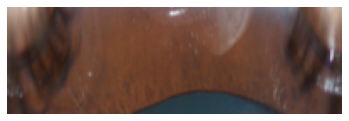

In [ ]:
images, labels = randomSample(testDataLoader)
print(f"Image batch shape: {images.size()}")
print(f"Labels batch shape: {len(labels)}")
imshow(images[0], f"Encoded label: {labels[0].item()}")

## Extract features

In [ ]:
def extractFeatures(dataloader, model, savePath='', asPandasDF=True):
  newData = None
  labels = None
  for i, (img, label) in enumerate(dataloader):
      print(f"Batch number: {i + 1}/{len(dataloader)}")
      
      with torch.no_grad():
        feature = model(img.to(device)).cpu().numpy()
        if newData is None:
          newData = feature
          labels = label.numpy()
        else:
          newData = np.vstack((feature, newData))
          labels = np.hstack((label.numpy(), labels))
  
  labels = labels.reshape(labels.shape + (1,))
  dataPDF = pd.DataFrame(data=np.hstack((newData, labels)), index=[i for i in range(newData.shape[0])], columns=['f'+str(i+1) for i in range(newData.shape[1])]+["label"])
  if savePath != '':
    dataPDF.to_csv(savePath, index=False)
  if asPandasDF:
    return dataPDF
  else: 
    return (newData, labels)

Extracting features using the "not touched" pretrained vgg...

In [ ]:
vggFEPretrainedFeatures = extractFeatures(testDataLoader, vggFEPretrained)

Batch number: 1/8
Batch number: 2/8
Batch number: 3/8
Batch number: 4/8
Batch number: 5/8
Batch number: 6/8
Batch number: 7/8
Batch number: 8/8


Extracting features using the vggfe finetuned using pair few-shot learning

In [ ]:
vggFEPairFeatures = extractFeatures(testDataLoader, vggFEPair)

Batch number: 1/8
Batch number: 2/8
Batch number: 3/8
Batch number: 4/8
Batch number: 5/8
Batch number: 6/8
Batch number: 7/8
Batch number: 8/8


Extracting features using the vggfe finetuned using triplet few-shot learning

In [ ]:
vggFETripletFeatures = extractFeatures(testDataLoader, vggFETriplet)

Batch number: 1/8
Batch number: 2/8
Batch number: 3/8
Batch number: 4/8
Batch number: 5/8
Batch number: 6/8
Batch number: 7/8
Batch number: 8/8


Extracting features using the FeatNet finetuned using triplet few-shot learning

In [ ]:
featNetTripletFeatures = extractFeatures(testDataLoader, featNetTriplet)

Batch number: 1/8
Batch number: 2/8
Batch number: 3/8
Batch number: 4/8
Batch number: 5/8
Batch number: 6/8
Batch number: 7/8
Batch number: 8/8


## Distance matrix

In [ ]:
from scipy.spatial.distance import squareform, pdist, cdist

def computeDistanceMatrix(features, metric='euclidean'):
  return pd.DataFrame(squareform(pdist(features.iloc[:, :-1], metric=metric)), 
                      columns=features.index, index=features.index)

## Testing functions for verification phase

In [ ]:
def getId(encodedLabel, dataset, subject=True):
  id = dataset.labelToId(int(encodedLabel))
  if subject:
    return id[:-1]
  else:
    return id

def verification(distanceMatrix, thresholds, features, dataset):
  # dictionary that will contain all the results
  results = {t : dict() for t in thresholds}
  rows, cols = distanceMatrix.shape
  for index, t in enumerate(thresholds):
    # For each treshold we test the method
    ga, fa, fr, gr = 0, 0, 0, 0
    for y in range(rows):
      rowLabel = getId(features.iloc[y].label, dataset)
      # results are grouped by label (here we're doing verification with multiple templates)
      groupedResults = dict()
      for x in range(cols):
        # same probe => skip
        if x == y: continue
        # column label
        colLabel = getId(features.iloc[x].label, dataset)
        # storing results
        groupedResults.setdefault(colLabel, []).append(distanceMatrix[y, x])
      for label in groupedResults:
        # take minimum distance between templates
        d = min(groupedResults[label])
        if d < t:
          # we have an acceptance, genuine or false?
          if rowLabel == label: ga += 1
          else: fa += 1
        else:
          # we have a rejection, genuine or false?
          if rowLabel == label: fr +=1
          else: gr += 1
    results[t] = {'gar': ga/rows, 'far': fa/(rows*(len(groupedResults)-1)), 'frr': fr/rows, 'grr': gr/(rows*(len(groupedResults)-1))}
    if index % (len(thresholds)//10) == 0:
      print(f"gar: {results[t]['gar']}\t far: {results[t]['far']}\t frr: {results[t]['frr']}\t grr: {results[t]['grr']}")
  return results

def plotVerificationResults(results):
  fig, (axERR, axROC) = plt.subplots(ncols=2)
  fig.set_size_inches(10,5)
  thresholds = []
  fars = []
  frrs = []
  for t in results:
    thresholds += [t]
    fars += [results[t]['far']]
    frrs += [results[t]['frr']]

  axERR.plot(thresholds, fars, 'r--', label='FAR')
  axERR.plot(thresholds, frrs, 'g--', label='FRR')
  axERR.legend(loc='upper center', shadow=True, fontsize='x-large')
  axERR.set_xlabel('Threshold')
  axERR.title.set_text('FAR vs FRR')

  axROC.plot(fars, list(map(lambda frr: 1-frr, frrs)))
  axROC.set_ylabel('1-FRR')
  axROC.set_xlabel('FAR')
  axROC.title.set_text('ROC Curve')

  plt.show()

## Testing functions for identification phase open-set

In [ ]:
def similarTo(probeIdx, features, distanceMatrix):
  similarities = list(sorted([i for i in range(distanceMatrix[probeIdx].shape[0])], key=lambda i: distanceMatrix[probeIdx][i]))
  similarities.remove(probeIdx)
  return similarities

def identification(distanceMatrix, thresholds, features, dataset):
  # dictionary that will contain all the results
  results = {t : dict() for t in thresholds}
  rows, cols = distanceMatrix.shape
  di = {t:[0 for _ in range(rows)] for t in thresholds}
  _dir = {t: [0 for _ in range(rows)] for t in thresholds}
  for index, t in enumerate(thresholds):
    fa, gr = 0, 0
    for y in range(rows):
      rowLabel = getId(features.iloc[y].label, dataset)
      similarIndex = similarTo(y, features, distanceMatrix)
      if distanceMatrix[y][similarIndex[0]] <= t:
        if rowLabel == getId(features.iloc[similarIndex[0]].label, dataset):
          di[t][0] += 1
          # find impostor case
          for k in similarIndex:
            if rowLabel != getId(features.iloc[k].label, dataset) and distanceMatrix[y][k] <= t: 
              fa += 1
              break
        else:
          for k, indexAtRankK in enumerate(similarIndex):
            if rowLabel == getId(features.iloc[indexAtRankK].label, dataset) and distanceMatrix[y][indexAtRankK] <= t:
              fa += 1
              di[t][k] += 1
              break
      else:
        gr += 1
    _dir[t][0] = di[t][0]/rows
    for i in range(1, rows):
      _dir[t][i] = di[t][i]/rows+_dir[t][i-1]
    results[t] = {'far': fa/rows, 'grr': gr/rows, 'dir': _dir[t], 'frr': 1-_dir[t][0]}
    if index % (len(thresholds)//10) == 0:
      print(f"dir({t}, 1): {results[t]['dir'][0]}\t far: {results[t]['far']}\t frr: {results[t]['frr']}\t grr: {results[t]['grr']}")
  return results

def cumulativeMatchingScore(distanceMatrix, features, dataset):
  rows, cols = distanceMatrix.shape
  cms = [0 for _ in range(rows)]
  for y in range(rows):
    rowLabel = getId(features.iloc[y].label, dataset)
    similarIndex = similarTo(y, features, distanceMatrix)
    for k, indexAtRankK in enumerate(similarIndex):
      if rowLabel == getId(features.iloc[indexAtRankK].label, dataset):
        cms[k] += 1
        break
  # rr
  cms[0] = cms[0]/rows
  for k in range(1, rows):
    cms[k] = cms[k]/rows + cms[k-1]
  return cms

def plotIdentificationResults(results, cms):
  fig, (axERR, axDIR, axCMS) = plt.subplots(ncols=3)
  fig.set_size_inches(20,5)
  thresholds = []
  fars = []
  frrs = []
  dir1 = []
  for t in results:
    thresholds += [t]
    fars += [results[t]['far']]
    frrs += [results[t]['frr']]
    dir1 += [results[t]['dir'][0]]


  # FAR vs FRR
  axERR.plot(thresholds, fars, 'r--', label='FAR')
  axERR.plot(thresholds, frrs, 'g--', label='FRR')
  axERR.set_xlabel('Threshold')
  axERR.legend(loc='upper center', shadow=True, fontsize='x-large')
  axERR.title.set_text('FAR and FRR')
  
  # DIR(t, 1)
  axDIR.plot(thresholds, dir1)
  axDIR.set_xlabel('Threshold')
  axDIR.set_ylabel('DIR at rank 1')
  axDIR.title.set_text('DIR(t, 1)')

  # CMS
  axCMS.plot(range(1, len(cms)+1), cms)
  axCMS.set_xlabel('Rank')
  axCMS.set_ylabel('Probability of identification')
  axCMS.title.set_text('CMC')

  
  plt.show()

## Testing VggFE Pretrained

Verification:
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.07563025210084033	 far: 0.0011204481792717086	 frr: 0.9243697478991597	 grr: 0.9988795518207283
gar: 0.33613445378151263	 far: 0.013445378151260505	 frr: 0.6638655462184874	 grr: 0.9865546218487395
gar: 0.6470588235294118	 far: 0.1753501400560224	 frr: 0.35294117647058826	 grr: 0.8246498599439775
gar: 0.8739495798319328	 far: 0.4504201680672269	 frr: 0.12605042016806722	 grr: 0.5495798319327732
gar: 0.9495798319327731	 far: 0.6655462184873949	 frr: 0.05042016806722689	 grr: 0.334453781512605
gar: 0.9747899159663865	 far: 0.826890756302521	 frr: 0.025210084033613446	 grr: 0.173109243697479
gar: 0.9831932773109243	 far: 0.9165266106442577	 frr: 0.01680672268907563	 grr: 0.08347338935574229
gar: 0.9831932773109243	 far: 0.9591036414565827	 frr: 0.01680672268907563	 grr: 0.04089635854341737


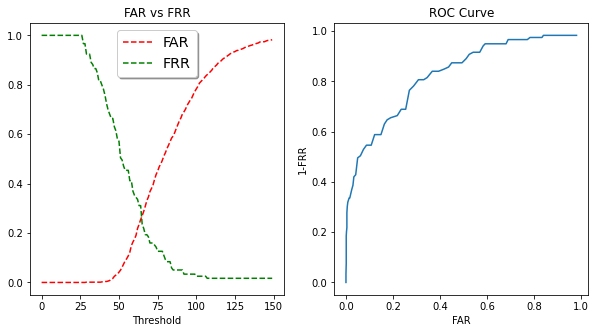

Identification:
dir(0, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(15, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(30, 1): 0.07563025210084033	 far: 0.0	 frr: 0.9243697478991597	 grr: 0.907563025210084
dir(45, 1): 0.3277310924369748	 far: 0.10084033613445378	 frr: 0.6722689075630253	 grr: 0.6050420168067226
dir(60, 1): 0.5378151260504201	 far: 0.5378151260504201	 frr: 0.46218487394957986	 grr: 0.2689075630252101
dir(75, 1): 0.6302521008403361	 far: 0.8067226890756303	 frr: 0.3697478991596639	 grr: 0.10084033613445378
dir(90, 1): 0.680672268907563	 far: 0.9243697478991597	 frr: 0.31932773109243695	 grr: 0.03361344537815126
dir(105, 1): 0.6890756302521008	 far: 0.9663865546218487	 frr: 0.31092436974789917	 grr: 0.01680672268907563
dir(120, 1): 0.6890756302521008	 far: 0.9831932773109243	 frr: 0.31092436974789917	 grr: 0.008403361344537815
dir(135, 1): 0.6890756302521008	 far: 0.9831932773109243	 frr: 0.31092436974789917	 grr: 0.008403361344537815


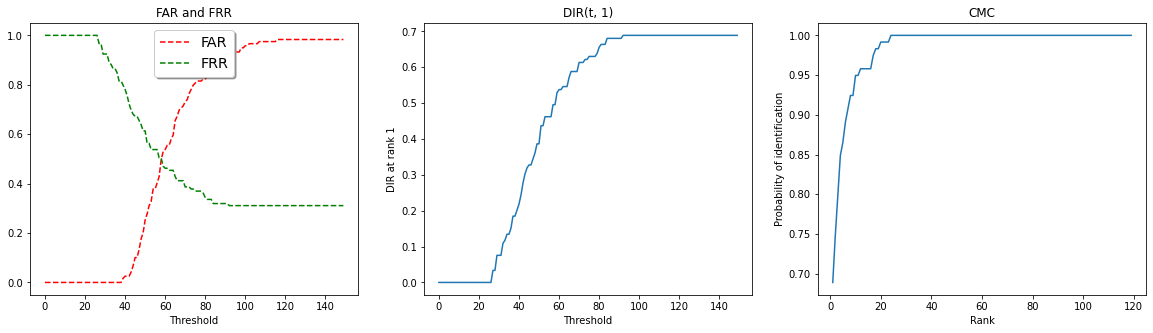

In [ ]:
dm = computeDistanceMatrix(vggFEPretrainedFeatures).to_numpy()
thresholds = [t for t in range(0, 150, 1)]

# verification
print("Verification:")
verificationResults = verification(dm, thresholds, vggFEPretrainedFeatures, testDataset)
plotVerificationResults(verificationResults)

# identification
print("Identification:")
identificationResults = identification(dm, thresholds, vggFEPretrainedFeatures, testDataset)
cms = cumulativeMatchingScore(dm, vggFEPretrainedFeatures, testDataset)
plotIdentificationResults(identificationResults, cms)

## Testing VggFE finetuned using pair few-shot learning

In [ ]:
vggFEPairFeatures.std()

f1       0.000000
f2       0.000000
f3       0.000000
f4       0.000000
f5       0.000000
           ...   
f4093    0.000000
f4094    0.000000
f4095    0.000000
f4096    0.000000
label    9.122776
Length: 4097, dtype: float64

Since the **std of each feature is very low** (so low that we cannot store it as a floating point), I decided to **discard this approach**.

I've done evaluation just to demonstrate that this approach leaks everywhere..

Verification:
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0
gar: 1.0	 far: 1.0	 frr: 0.0	 grr: 0.0


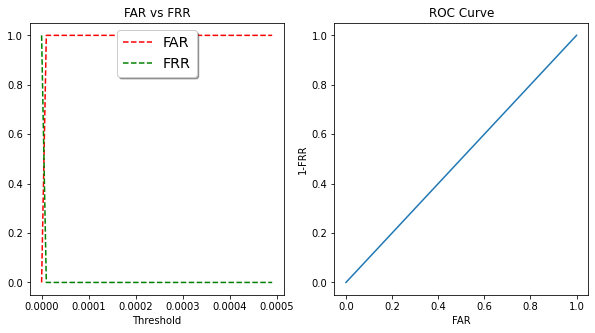

Identification:
dir(0.0, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(5e-05, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.0001, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.00015, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.0002, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.00025, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.0003, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.00035, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.0004, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0
dir(0.00045, 1): 0.058823529411764705	 far: 1.0	 frr: 0.9411764705882353	 grr: 0.0


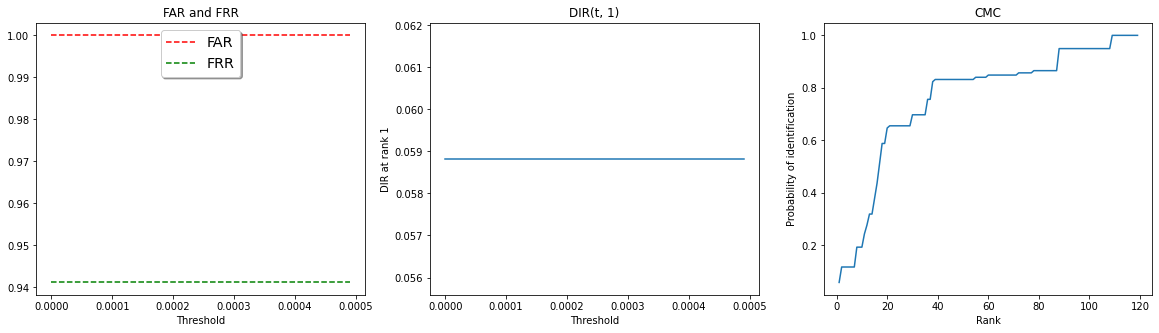

In [ ]:
dm = computeDistanceMatrix(vggFEPairFeatures).to_numpy()
thresholds = [t/100000 for t in range(0, 50, 1)]

# verification
print("Verification:")
verificationResults = verification(dm, thresholds, vggFEPairFeatures, testDataset)
plotVerificationResults(verificationResults)

# identification
print("Identification:")
identificationResults = identification(dm, thresholds, vggFEPairFeatures, testDataset)
cms = cumulativeMatchingScore(dm, vggFEPairFeatures, testDataset)
plotIdentificationResults(identificationResults, cms)

## Testing VggFE finetuned using triplet few-shot learning
Testing verification multiple template

Verification:
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.01680672268907563	 far: 0.0	 frr: 0.9831932773109243	 grr: 1.0
gar: 0.20168067226890757	 far: 0.0011204481792717086	 frr: 0.7983193277310925	 grr: 0.9988795518207283
gar: 0.6554621848739496	 far: 0.01904761904761905	 frr: 0.3445378151260504	 grr: 0.9809523809523809
gar: 0.8571428571428571	 far: 0.13053221288515407	 frr: 0.14285714285714285	 grr: 0.869467787114846
gar: 0.957983193277311	 far: 0.30532212885154064	 frr: 0.04201680672268908	 grr: 0.6946778711484594
gar: 1.0	 far: 0.45322128851540616	 frr: 0.0	 grr: 0.5467787114845938
gar: 1.0	 far: 0.5708683473389355	 frr: 0.0	 grr: 0.4291316526610644
gar: 1.0	 far: 0.6655462184873949	 frr: 0.0	 grr: 0.334453781512605


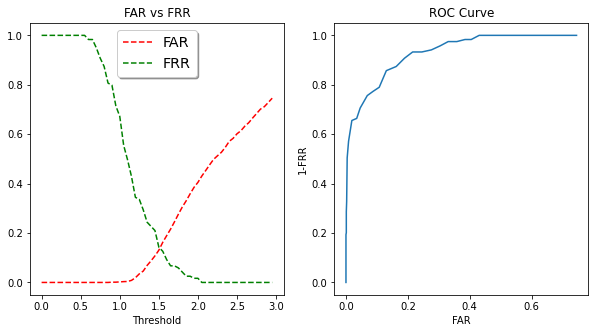

Identification:
dir(0.0, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(0.3, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(0.6, 1): 0.01680672268907563	 far: 0.0	 frr: 0.9831932773109243	 grr: 0.9831932773109243
dir(0.9, 1): 0.20168067226890757	 far: 0.008403361344537815	 frr: 0.7983193277310925	 grr: 0.7899159663865546
dir(1.2, 1): 0.6134453781512605	 far: 0.19327731092436976	 frr: 0.38655462184873945	 grr: 0.29411764705882354
dir(1.5, 1): 0.7142857142857143	 far: 0.6386554621848739	 frr: 0.2857142857142857	 grr: 0.025210084033613446
dir(1.8, 1): 0.7142857142857143	 far: 0.8823529411764706	 frr: 0.2857142857142857	 grr: 0.0
dir(2.1, 1): 0.7142857142857143	 far: 1.0	 frr: 0.2857142857142857	 grr: 0.0
dir(2.4, 1): 0.7142857142857143	 far: 1.0	 frr: 0.2857142857142857	 grr: 0.0
dir(2.7, 1): 0.7142857142857143	 far: 1.0	 frr: 0.2857142857142857	 grr: 0.0


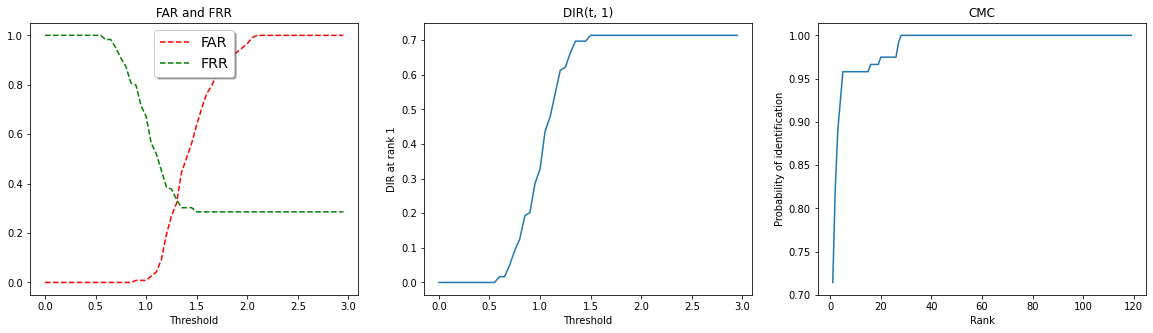

In [ ]:
dm = computeDistanceMatrix(vggFETripletFeatures).to_numpy()
thresholds = [t/100 for t in range(0, 250, 2)]

# verification
print("Verification:")
verificationResults = verification(dm, thresholds, vggFETripletFeatures, testDataset)
plotVerificationResults(verificationResults)

# identification
print("Identification:")
identificationResults = identification(dm, thresholds, vggFETripletFeatures, testDataset)
cms = cumulativeMatchingScore(dm, vggFETripletFeatures, testDataset)
plotIdentificationResults(identificationResults, cms)

## Testing FeatNet trained using triplet few-shot learning

Verification:
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
gar: 0.1092436974789916	 far: 0.0	 frr: 0.8907563025210085	 grr: 1.0
gar: 0.453781512605042	 far: 0.012324929971988795	 frr: 0.5462184873949579	 grr: 0.9876750700280112
gar: 0.7815126050420168	 far: 0.14173669467787114	 frr: 0.2184873949579832	 grr: 0.8582633053221288
gar: 0.9663865546218487	 far: 0.48627450980392156	 frr: 0.03361344537815126	 grr: 0.5137254901960784
gar: 0.9831932773109243	 far: 0.7848739495798319	 frr: 0.01680672268907563	 grr: 0.21512605042016808
gar: 1.0	 far: 0.9204481792717086	 frr: 0.0	 grr: 0.07955182072829131
gar: 1.0	 far: 0.9753501400560224	 frr: 0.0	 grr: 0.02464985994397759


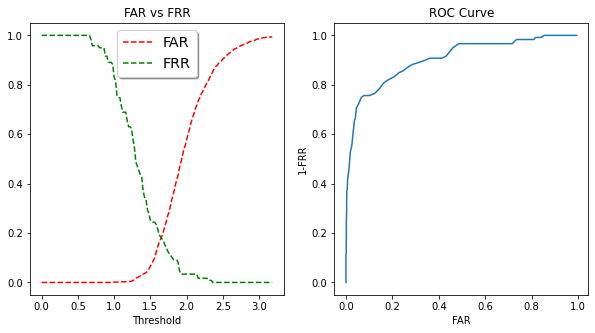

Identification:
dir(0.0, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(0.32, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(0.64, 1): 0.0	 far: 0.0	 frr: 1.0	 grr: 1.0
dir(0.96, 1): 0.1092436974789916	 far: 0.0	 frr: 0.8907563025210083	 grr: 0.8907563025210085
dir(1.28, 1): 0.44537815126050423	 far: 0.09243697478991597	 frr: 0.5546218487394958	 grr: 0.5210084033613446
dir(1.6, 1): 0.7058823529411765	 far: 0.4117647058823529	 frr: 0.2941176470588235	 grr: 0.19327731092436976
dir(1.92, 1): 0.7983193277310925	 far: 0.8235294117647058	 frr: 0.2016806722689075	 grr: 0.025210084033613446
dir(2.24, 1): 0.7983193277310925	 far: 0.957983193277311	 frr: 0.2016806722689075	 grr: 0.0
dir(2.56, 1): 0.7983193277310925	 far: 1.0	 frr: 0.2016806722689075	 grr: 0.0
dir(2.88, 1): 0.7983193277310925	 far: 1.0	 frr: 0.2016806722689075	 grr: 0.0


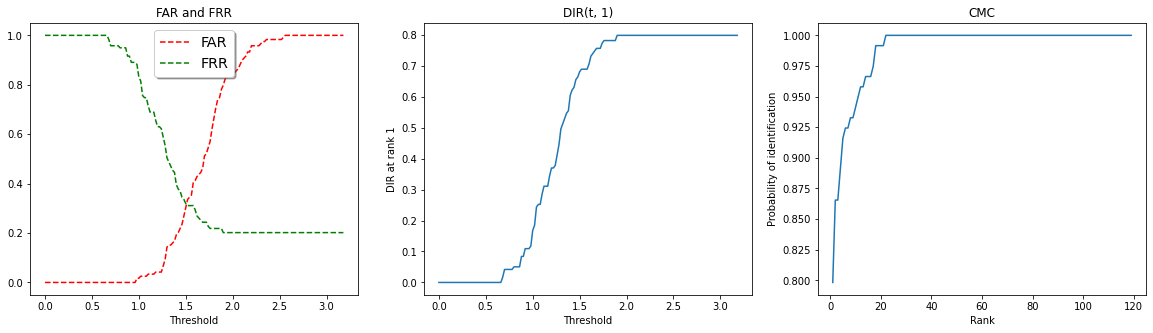

In [ ]:
dm = computeDistanceMatrix(featNetTripletFeatures).to_numpy()
thresholds = [t/100 for t in range(0, 320, 2)]

# verification
print("Verification:")
verificationResults = verification(dm, thresholds, featNetTripletFeatures, testDataset)
plotVerificationResults(verificationResults)

# identification
print("Identification:")
identificationResults = identification(dm, thresholds, featNetTripletFeatures, testDataset)
cms = cumulativeMatchingScore(dm, featNetTripletFeatures, testDataset)
plotIdentificationResults(identificationResults, cms)